# Reformat data

## Summary

Reformat data for descriptive analysis.

## Aims

Restrict clean data (from 01_clean_raw_data.ipynb) to:
* Years for each hospital where they have at least 20 admissions.
* Arrivals within four hours of known onset.

## Set up

In [1]:
# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'clean_samuel_ssnap_extract_v2.csv'
    restrict_filename = 'reformatted_data.csv'
    notebook = '01'


paths = Paths()

In [4]:
# Load data
raw_data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))

## Restrict by number of admissions

We also want to remove very small centres (i.e. not considered "stroke units", not routinely receiving patients).

To determine an appropriate threshold of a "small centre", reviewed the number of admissions and thrombolysis patients per year for hospitals where they had any year with either (a) less than 100 admissions, or (b) less than 3 thrombolysis patients.

In [5]:
# Create empty object to store rows
discard = []

# Loop through name (each stroke team) and group_df (relevant rows
# from data)
groups = raw_data.groupby('stroke_team')
for name, group_df in groups:
    # Find admissions and thrombolysis use per year
    test_restrictions = pd.concat(
        [group_df.groupby('year').size().rename('admissions'),
         group_df.groupby('year')['thrombolysis'].sum()],
        axis=1).reset_index()
    test_restrictions['stroke_team'] = name

    # Check if any year fail conditions over the whole time period
    if (any(test_restrictions['admissions'] < 100) or
            any(test_restrictions['thrombolysis'] < 3)):
        discard.append(test_restrictions)

# Convert into a dataframe
admissions_thrombolysis = pd.concat(discard)
display(admissions_thrombolysis)

,year,admissions,thrombolysis,stroke_team
0,2016,110,24,Bronglais Hospital
1,2017,96,18,Bronglais Hospital
2,2018,107,28,Bronglais Hospital
3,2019,91,21,Bronglais Hospital
4,2020,94,21,Bronglais Hospital
5,2021,87,24,Bronglais Hospital
0,2020,77,3,Grange University Hospital
1,2021,416,51,Grange University Hospital
0,2016,916,100,Leeds General Infirmary
1,2017,750,73,Leeds General Infirmary


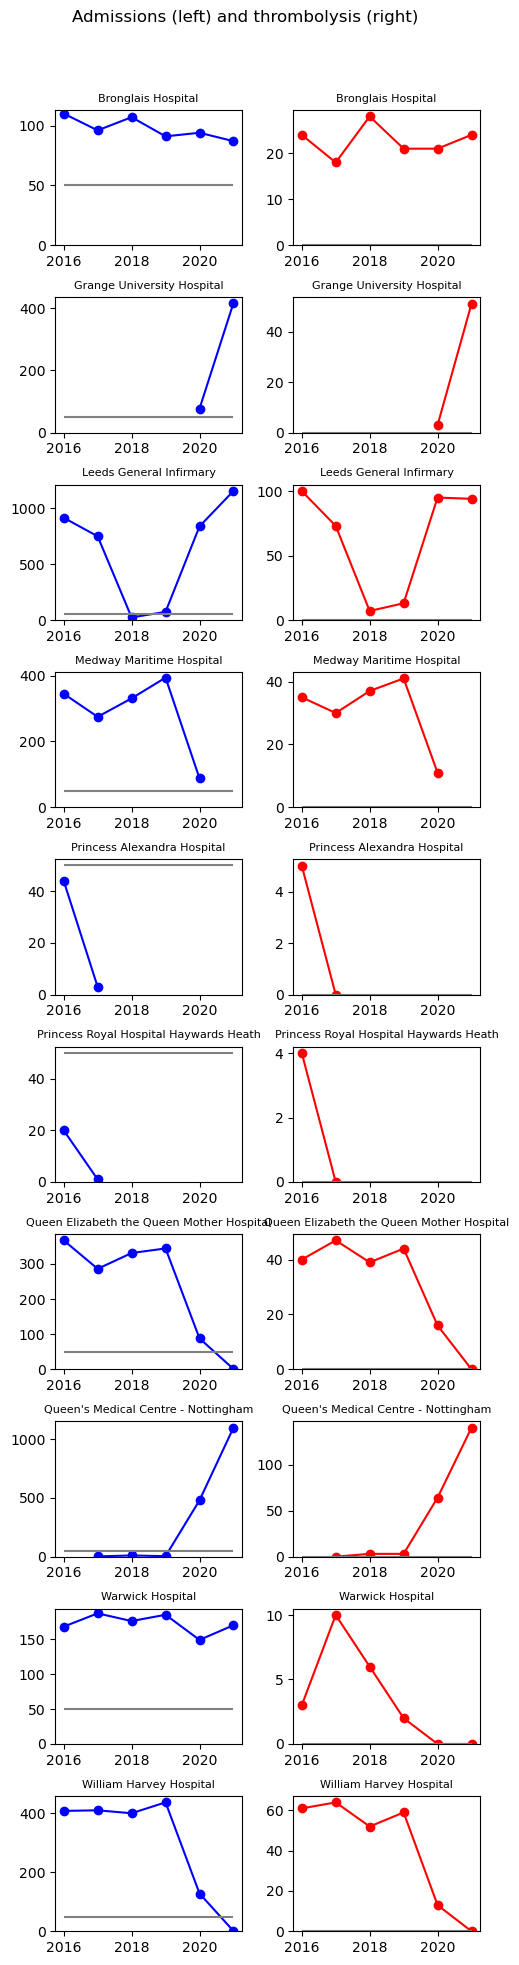

In [6]:
# Group by stroke team and loop through
admissions_thrombolysis_teams = (
    admissions_thrombolysis.groupby('stroke_team'))

# Set up figure and counter
fig, ax = plt.subplots(
    figsize=(5, 20), nrows=len(admissions_thrombolysis_teams), ncols=2)
i = 0

# Loop through teams and plot
for name, group_df in admissions_thrombolysis_teams:
    # Admissions plot
    group_df.plot(x='year', y='admissions', linestyle='-', marker='o',
                  ax=ax[i, 0], color='blue', legend=False, xlabel='')
    ax[i, 0].hlines(y=50, xmin=2016, xmax=2021, color='grey')
    ax[i, 0].set_ylim([0, None])
    ax[i, 0].set_title(name, fontsize=8)

    # Thrombolysis patients plot
    group_df.plot(x='year', y='thrombolysis', linestyle='-', marker='o',
                  ax=ax[i, 1], color='red', legend=False, xlabel='')
    ax[i, 1].hlines(y=0, xmin=2016, xmax=2021, color='grey')
    ax[i, 1].set_ylim([0, None])
    ax[i, 1].set_title(name, fontsize=8)

    i += 1

fig.tight_layout()
fig.suptitle('Admissions (left) and thrombolysis (right)')
fig.subplots_adjust(top=0.93)
plt.show()

Suggested restrictions:
* **Minimum of 50 admissions per year** - this means we drop really small hospitals (three have no more than 10 per year), but still keep fairly small (one has around 90-100 admissions per year).
* **No minimum number of thrombolysis patients** - as there are hospitals like Warwick Hospital with around 180 admissions per year but only 2 to 10 thrombolysis patients per year.
* **Check these criteria year by year** - keep years where they meet criteria and drop years where they don't (as centres open and close, and only want years where they were actually open)

*(Agreed threshold with MA, KP, AL & AH on 02/06/2023)*

In [7]:
# Create empty object to store rows
keep = []

# Group by stroke team and year and check criteria
groups = raw_data.groupby(['stroke_team', 'year'])
for name, group_df in groups:
    # Check if year meets conditions
    if (len(group_df.index) >= 50):
        keep.append(group_df)

# Concatenate to create dataframe
raw_data_size = pd.concat(keep)

In [8]:
# Printing number of stroke teams kept v.s. removed
n_raw_team = len(raw_data['stroke_team'].unique())
n_clean_team = len(raw_data_size['stroke_team'].unique())
print('N stroke teams with at least 1 year kept: {0}'.format(n_clean_team))
print('N stroke teams fully removed: {0}'.format(
    n_raw_team - n_clean_team
))

N stroke teams with at least 1 year kept: 119
N stroke teams fully removed: 2


## Restrict by onset to arrival time

This project is just focussed on the **emergency stroke pathway**, and hence we have focussed on individuals who arrived with **four** hours of **known** onset

In [9]:
data = raw_data_size[(raw_data_size['onset_known'] == 1) &
                     (raw_data_size['onset_to_arrival_time'] <= 4*60)]

## Save data

In [10]:
# Save restricted dataset
filename = os.path.join(paths.data_path, paths.restrict_filename)
data.to_csv(filename, index=False)

## Appendices

### Previous restrictions

This section notes down previous restrictions we used, and why we are no longer using them here.

**Year:** We had assumed that 2016 would be too long ago, and that 2020 onwards would be impacted by COVID-19, but we have chosen to include them, so we can see to what extent results vary year-to-year, and if there might be a possibility of using other years (and not just 2017-2019).

**Arrival by ambulance:** We had previously considered restricting descriptive analysis to only individuals who arrived by ambulance, as we are focussed on the emergency stroke pathway, which often means arriving by ambulance, with the ambulance often being the trigger of the start of the pathway. We decided not to, as we know that there will be some emergency patients who do manage to get on the emergency pathway, despite not arriving by ambulance.

**Number of thrombolysis patients per year:** As above, there are some hospitals with a reasonable number of admissions but very low numbers of thrombolysis patients (e.g . 0, 1, 2) that would be relevant to include.